# 2. Adding services to the simulation

Service is a key component to the simulation that defines a running scenario for your experiment.
Each service has access to peer class and Simpy environment. 

At the moment simulation has two abstract service classes: 
1. Runner  
2. Handler


### **Runner**

Runner works as a producer of events, or when you require an action initiative from a peer. For example, a message producer is a runner.

Function to implement: `run()`


### **Handler**

Handler works as a reactive service that handles incoming messages. 

Functions to implement: 
 - `handle_message(msg)` - react upon recieving a message.
 - `@property messages` - list of messages that this service can handle.  


For example, a connection manager is both a runner and a handler as it produces and reacts on messages. 



# Creating new services


The simulation at this point is not very useful. 
Let's create our own service on top of what we have now, i.e. let's build a gossip network.


A gossip protocol ([wiki](https://en.wikipedia.org/wiki/Gossip_protocol)) is an important building block used in almost any P2P system(for example: [hyperledger gossip](https://hyperledger-fabric.readthedocs.io/en/release-1.4/gossip.html), [course slides](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf)). 


## Gossip Message Handler

There are multiple ways to implement Gossip: [ttl, anti-entropy etc](http://www.cs.cornell.edu/Projects/Quicksilver/public_pdfs/2007PromiseAndLimitations.pdf).

We will implement one of the simplest versions based on ttl (Time to live), where each message has a predefined $ttl$ parameter. $ttl$ shows a stoping condition for the peer, i.e. if $ttl$=0, the peer should stop, otherwise $ttl$ must be decremented and the message should be gossiped further.

Let's first implement a handler: a service that reacts on incoming gossip messages: 


In [22]:
# Message gossip
from p2psimpy import *
from p2psimpy.services.base import BaseHandler
from p2psimpy.messages import BaseMessage
from p2psimpy.storage import Storage

from re import split 
from copy import copy

# Define a special message GossipMessage: Message with ttl
class GossipMessage(BaseMessage):

    __slots__ = ('sender', 'data', 'ttl')
    size = 1024
    
    def __init__(self, sender, data, ttl):
        super().__init__(sender, data)
        self.ttl = ttl
        
class GossipService(BaseHandler):
    """
    A simple gossip service to handle the gossip messages and pass them to the neighbors. 
    """

    def __init__(self, peer, fanout=3, exclude_peers: set=None, exclude_types: set=None, optimization=True):
        super().__init__(peer)
        
        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set() 
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types
        
        self.optimization = optimization
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())

    def handle_message(self, msg):
        # Store message localy 
        msg_id = msg.data
        
        already_seen = False
        # If optimization is enabled, then drop the message if we have already seen it.
        if self.optimization:
            already_seen = (self.peer.get_storage(self.strg_name).get(msg_id) != None)
              
        # Store the message id received with the current timestamp
        self.peer.store(self.strg_name, msg_id, self.peer.env.now)
        if msg.ttl > 0 and not already_seen:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers
            # Use peer gossip - it will sample self.config.fanout and exclude sender
            # If you need to exclude some peers: add it to the set
            self.peer.gossip( GossipMessage(self.peer, msg.data, msg.ttl-1), 
                             self.fanout, except_peers=exclude_peers, except_type=self.exclude_types)

    @property
    def messages(self):
        return GossipMessage,


The Peer object has a gossip function that will send a message to a random sample of `fanout` connected peers.
Peers are included in `except_peers` and `except_type` are excluded from the sampling. 


The service implements a reaction on the messages specified in the `messages` property and reacts as follows: 
- Peer stores the message when it is received and keeps the timestamp when the message was received - `self.peer.env.now`. Note also that to store the message first we need to initilize it via `self.peer.add_storage(storage_name, storage_object)`. 
- If the message ttl is positive, the peer sends the message to the `fanout` number of random connected peers with a function `self.peer.gossip(Msg, fanout)`. You can also exclude some peers from the sampling like excluding the sender of the message (from which you get the message) is a reasonable optimization. 





## Message producer 

Finally, we need to create a service that will first create (produce) the message. 
We will inherit a MessageProducer from a `BaseRunner` class.

MessageProducer will have `msg_rate`, `ttl`, `fanout` and a `timeout_delay`.




In [23]:
from p2psimpy.services.base import BaseRunner

class MessageProducer(BaseRunner):

    def __init__(self, peer, init_timeout=1000, msg_rate=5, init_ttl=3, init_fanout=10, msg_count=20):
        '''
        init_timeout: milliseconds to wait before starting the message production. 
        msg_rate: number of messages per second
        init_ttl: ttl to set up for the message 
        init_fanout: to how many peer send the message to
        '''
        super().__init__(peer)

        # calculate tx_interval
        self.init_timeout = init_timeout
        self.init_ttl = init_ttl
        self.init_fanout = init_fanout
        
        self.tx_interval = 1000 / msg_rate
        self.counter = 1
        
        # Note that we are going to limit the number of messages. Because, depending on the network
        # topology, messages might take longer time to converge. And therefore when simulation ends, last few messages in the
        # run might not have been converged, which leads to NaN values.
        self.msg_count = 20
        
        # Let's add a storage layer to store messages
        self.strg_name = 'msg_time'
        self.peer.add_storage(self.strg_name, Storage())


    def produce_transaction(self):
        # Create a gossip message: message counter, peer_id and gossip it   
        self.peer.gossip(GossipMessage(self.peer,
                                       '_'.join((str(self.counter), str(self.peer.peer_id))), 
                                       self.init_ttl), 
                         self.init_fanout)
        # Locally store the message counter 
        self.peer.store(self.strg_name, str(self.counter), self.peer.env.now)
        self.counter+=1
        

    def run(self):
        # Wait the initial timeout
        yield self.env.timeout(self.init_timeout)
        # while True:
        while self.counter <= self.msg_count:
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)

Notice that `yield time_to_wait` is used to simulate time and waiting in a simulation. 

-----

## Preparing an Experiment

In [24]:
# Define locations 
from p2psimpy.config import *
from p2psimpy.consts import *
from p2psimpy.services.connection_manager import BaseConnectionManager
import networkx as nx
from random import choice

import matplotlib.pyplot as plt

# We take the locations from AWS 
class Locations(Config):
    locations = ['Ohio', 'Ireland', 'Tokyo']
    latencies = {
        'Ohio': {'Ohio': Dist('invgamma', (5.54090, 0.333305, 0.987249)),
                 'Ireland': Dist('norm', (73.6995, 1.19583092197097127)),
                 'Tokyo': Dist('norm', (156.00904977375566, 0.09469886668079797))
                },
        'Ireland':{'Ireland': Dist('invgamma', (6.4360455224301525, 0.8312748033308526, 1.086191852963273)),
                   'Tokyo': Dist('norm', (131.0275, 0.25834811785650774))
                  },
        'Tokyo': {'Tokyo':  Dist('invgamma', (11.104508341331055, 0.3371934865734555, 2.0258998705983737))}
    }
    
# Define peer     
class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}
    
class LimitedMsgProducerConfig(Config):
    times = 20

# We have not two types of nodes: *peer* and *client*
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, (BaseConnectionManager, MessageProducer))}

def prepare_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.erdos_renyi_graph(num_peers, 0.4)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=100, label=1)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')


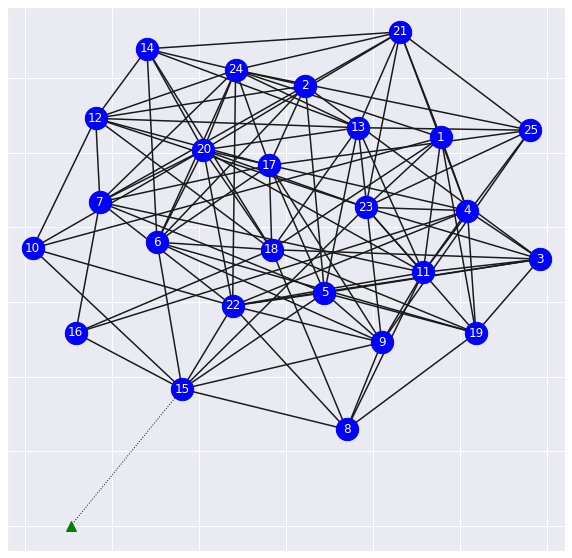

In [25]:
# Prepare and show target network topology 
G = prepare_topology()
visualize_peer_client_network(G)

In [26]:
from time import time
from p2psimpy.simulation import BaseSimulation

net_sim = BaseSimulation(Locations, G, prepare_peer_types())

In [27]:

net_sim.run(5_200)


One of the main properties that we need to achieve with gossip is **convergence**.
**Convergence** is a state where every peer has received the required message. 
The gossip protocols are compared with each other using the **time to convergence** metric.


We can find it by inspecting the time when peer has the received message by looking at `peer.storage`.
For this experiment we used a simple dictionary - *first-seen* storage. 

In [28]:
client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']

client_id = client_nodes[0]
print("Time when message was produced by the client: {}\n{}".format(client_id,net_sim.peers[client_id].storage['msg_time'].txs))

# Put any peer id you want to inspect
client_edge = list(G.edges(nbunch=client_nodes))
peer_id = client_edge[0][1]

print("Time when the message was received by the peer: {}\n{}".format(peer_id, net_sim.peers[peer_id].storage['msg_time'].txs))

Time when message was produced by the client: 26
{'1': 1000, '2': 1200.0, '3': 1400.0, '4': 1600.0, '5': 1800.0, '6': 2000.0, '7': 2200.0, '8': 2400.0, '9': 2600.0, '10': 2800.0, '11': 3000.0, '12': 3200.0, '13': 3400.0, '14': 3600.0, '15': 3800.0, '16': 4000.0, '17': 4200.0, '18': 4400.0, '19': 4600.0, '20': 4800.0}
Time when the message was received by the peer: 15
{'1_26': 1000.2813020901681, '2_26': 1200.2895948135626, '3_26': 1400.2242726470897, '4_26': 1600.2791998657472, '5_26': 1800.2376715413998, '6_26': 2000.2196105602852, '7_26': 2200.2134637306185, '8_26': 2400.311286577976, '9_26': 2600.291123848688, '10_26': 2800.2832525523645, '11_26': 3000.249919870304, '12_26': 3200.3252056545684, '13_26': 3400.230696525871, '14_26': 3600.2327760660764, '15_26': 3800.277450799961, '16_26': 4000.2980556766893, '17_26': 4200.261325267347, '18_26': 4400.268625103692, '19_26': 4600.24942991481, '20_26': 4800.26939825869}


In [29]:
# Calculate the delay 

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
dict(total_delay(net_sim, peer_id, 'msg_time'))

{1: 0.28130209016808294,
 2: 0.28959481356264405,
 3: 0.2242726470897196,
 4: 0.2791998657471595,
 5: 0.2376715413997772,
 6: 0.21961056028521853,
 7: 0.2134637306185141,
 8: 0.3112865779758067,
 9: 0.29112384868813024,
 10: 0.28325255236450175,
 11: 0.24991987030398377,
 12: 0.3252056545684354,
 13: 0.230696525870826,
 14: 0.23277606607643975,
 15: 0.277450799961116,
 16: 0.29805567668927324,
 17: 0.26132526734727435,
 18: 0.26862510369210213,
 19: 0.24942991481020726,
 20: 0.26939825868976186}

In [30]:
dict(total_delay(net_sim, 2, 'msg_time'))

{1: 0.8007708127266824,
 2: 73.64097735896121,
 3: 73.17624361379012,
 5: 0.9669173659501666,
 7: 0.9942372494283518,
 9: 156.58192041911207,
 10: 156.63236339470905,
 11: 0.7827848245024143,
 13: 74.79158083565562,
 14: 156.28771202489452,
 15: 0.8202359063948279,
 16: 156.60326534185606,
 17: 72.92223673999888,
 19: 73.09539586289975,
 20: 73.53113392321939}

### Exercise

Try to play around with different peer_id values. Try peer that is directly connected to the client, then try peer that is on the edge of the network.

Try the same with an emergent topology.

In [31]:
# Here, we will to build an emergent topology.

from p2psimpy.services.connection_manager import P2PConnectionManager

def prepare_emergent_topo(num_peers=25, num_client=1):
    topology_specs = {}
    for i in range(1, num_peers+num_client+1):
        node_type = 'peer' if i < (num_peers+1) else 'client'
        topology_specs[i] = {'type': node_type}  
    return topology_specs
    
# Peers will be connected to minimum 4 to maximum 8 peers
class PeerConnectionConfig(Config):
    min_peers = 4
    max_peers = 8
    
# Client will be connected to only one peer 
class ClientConnectionConfig(Config):
    min_peers = 1
    max_peers = 1
    
# Configuration used to set the values of message producer
class ClientMsgProducerConfig(Config):
    init_timeout = 10000 # Add some delay so that the peer network is built before starting with this message.
    
# We have now two types of nodes: *peer* and *client*
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {P2PConnectionManager: PeerConnectionConfig,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, {P2PConnectionManager: ClientConnectionConfig, 
                                             MessageProducer: ClientMsgProducerConfig})}

net_emergent_sim = BaseSimulation(Locations, prepare_emergent_topo(25,1), prepare_peer_types(), logger_dir='logs2')

net_emergent_sim.run(15_000)

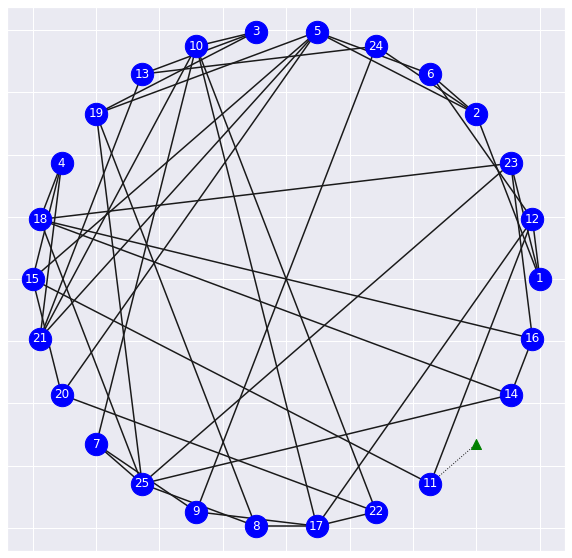

In [32]:
G1 = net_emergent_sim.get_graph()
visualize_peer_client_network(G1)

In [33]:
# Let's print some timings between the client and it's directly connected peer node.

client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G1,'type').items() if ty == 'client']

client_id = client_nodes[0]
print("Time when message was produced by the client: {}\n{}".format(client_id,net_sim.peers[client_id].storage['msg_time'].txs))

# Put any peer id you want to inspect
client_edge = list(G1.edges(nbunch=client_nodes))
peer_id = client_edge[0][1]

print("Time when the message was received by the peer: {}\n{}".format(peer_id, net_sim.peers[peer_id].storage['msg_time'].txs))

Time when message was produced by the client: 26
{'1': 1000, '2': 1200.0, '3': 1400.0, '4': 1600.0, '5': 1800.0, '6': 2000.0, '7': 2200.0, '8': 2400.0, '9': 2600.0, '10': 2800.0, '11': 3000.0, '12': 3200.0, '13': 3400.0, '14': 3600.0, '15': 3800.0, '16': 4000.0, '17': 4200.0, '18': 4400.0, '19': 4600.0, '20': 4800.0}
Time when the message was received by the peer: 11
{'1_26': 1036.5887827137742, '2_26': 1238.5860854748566, '3_26': 1437.2441191777073, '4_26': 1792.9160105405576, '5_26': 1838.3103546689426, '6_26': 2037.7531596843503, '7_26': 2236.665812546627, '8_26': 2438.132446125671, '9_26': 2709.6395120150996, '10_26': 2837.757381694219, '11_26': 3037.7564062825754, '12_26': 3236.941911100211, '13_26': 3436.089909994072, '14_26': 3636.831893671937, '15_26': 3967.4957681974056, '17_26': 4237.244122325063, '18_26': 4567.402182508351, '19_26': 4638.314445736243, '20_26': 4837.364287047582}


____________________________

# Analyze and visualize  gossip


When implementing gossip it is important to analyze following: 
 - What is the average time for the peer to receive a message? 
 - What is the convergence speed for my gossip protocol? 
 - Can we guarantee that all peers will see the message? At what time message is finalized?   


Let's go one by one and answer these questions for this gossip protocol implementation. 


## Convergence

In [34]:
import pandas as pd

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for k, peer_time in store.items():
        msg_num, client_id = k.split('_')
        client_time = sim.peers[int(client_id)].storage[storage_name].txs[msg_num]
        yield (int(msg_num), peer_time - client_time)
        
def get_gossip_table(sim, storage_name):
    return pd.DataFrame({k: dict(total_delay(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()
df = get_gossip_table(net_sim, 'msg_time')
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,NaN,0.800771,NaN,NaN,0.549626,1.076867,78.820298,NaN,0.558496,NaN,...,NaN,37.038041,72.351073,NaN,NaN,78.775596,37.338298,38.125426,102.340229,78.518578
2,39.073722,73.640977,39.052934,78.825318,NaN,0.551255,151.441760,38.035549,72.408952,NaN,...,NaN,36.296221,156.637083,78.572826,156.618630,NaN,NaN,37.601455,78.540929,NaN
3,37.795407,73.176244,37.341842,103.422576,72.956816,NaN,102.755860,NaN,74.721082,78.290443,...,103.706116,109.198743,156.541379,102.790486,74.247243,103.647577,36.741756,37.710547,NaN,NaN
4,143.830676,NaN,144.121343,209.301315,NaN,0.508150,103.189534,37.158042,0.540260,78.215370,...,NaN,37.618210,74.275861,78.458762,156.158578,209.162425,37.653371,143.900083,78.858756,78.573230
5,168.050094,0.966917,37.826535,NaN,NaN,0.755139,NaN,36.527276,0.464333,102.673456,...,NaN,35.833815,72.812046,78.784428,180.635719,102.880288,37.167561,38.358102,102.606978,102.880172
6,37.999031,NaN,38.260478,78.835234,NaN,0.524324,103.329475,37.401145,73.950242,NaN,...,NaN,36.569237,1.307760,78.589052,1.566438,102.508391,37.902305,37.170126,103.296714,NaN
7,37.147342,0.994237,NaN,101.956584,0.797006,0.779459,78.874683,NaN,0.539894,78.311500,...,NaN,167.340464,73.181696,78.737711,73.100390,101.937402,37.182467,36.208889,NaN,101.669995
8,167.918582,NaN,37.628479,102.641930,73.676353,0.939667,NaN,168.049104,0.521845,NaN,...,NaN,36.108090,1.234605,102.377482,72.832639,NaN,38.544720,37.059986,101.581554,101.503503
9,143.913039,156.581920,NaN,78.570265,156.487277,NaN,78.560021,37.460088,72.411210,78.261375,...,78.311965,192.609239,74.600385,78.813560,73.790583,NaN,36.917204,NaN,78.787687,150.410080
10,143.986066,156.632363,37.835667,101.181145,179.273264,NaN,NaN,NaN,179.020693,78.326778,...,101.429847,166.365911,180.315406,101.266876,NaN,NaN,37.308916,35.641099,NaN,100.993892


Code above should produce a table with the message number on the rows and peer id on the columns. 

You can also probably see `NaN` values in the table. These indicate that the gossip protocol didn't fully converge, and some peers never saw some messages. To guarantee convergence we either need to implement a gossip based on [set reconciliation](https://www.cse.ust.hk/~yike/sigmod14.pdf)  or tweak the parameters: `fanout` and `ttl`. We need to fine-tune the parameter to achieve the required effect. 

Usually gossip is fast to converge, but depends on the network topology. 

We can also represent our table as a heatmap. White color corresponds to `Nan`. You can see what peers are slower, or what message is least/most seen:

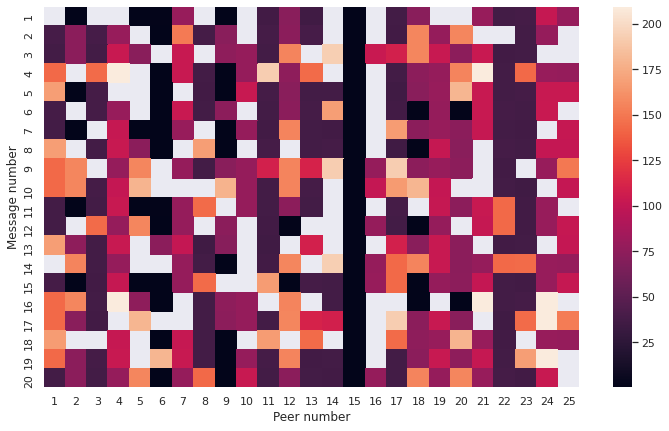

In [35]:
import seaborn as sns
sns.set()

def show_heat_map(df):
    plt.figure(figsize=(12, 7))
    ax = plt.axes()

    sns.heatmap(df, ax=ax)

    plt.xlabel('Peer number', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Message number', fontsize = 12) # y-axis label with fontsize 15

    plt.show()

show_heat_map(df)

## Average time 

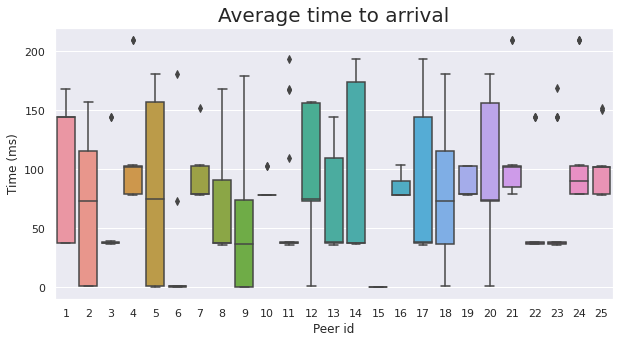

In [36]:
def show_avg_time(df):
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=df, )
    ax.set_title('Average time to arrival', fontsize= 20 )
    ax.set_ylabel('Time (ms)', fontsize=12)
    ax.set_xlabel('Peer id', fontsize=12)
    plt.show()
show_avg_time(df)

## Convergence speed

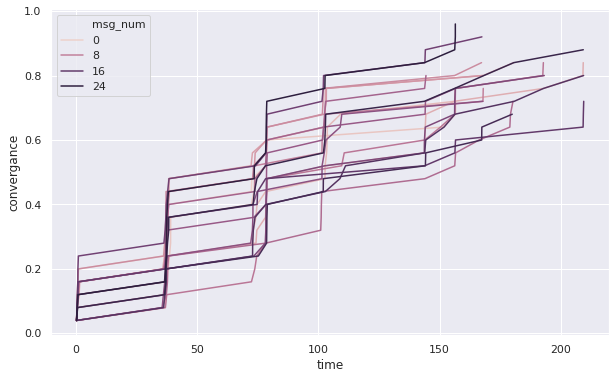

In [37]:
def conv(df):
    num_peers = len(df.columns)
    num_messages = len(df.index)
    
    
    a = df.values
    a.sort(axis=1)
    df2 = pd.DataFrame(a)
 

    df2.columns = ((i+1)/num_peers for i in df2.columns)
    df2.index = pd.RangeIndex(start=1, stop=num_messages+1, step=1)

    return df2.stack().reset_index().rename(columns={'level_0':'msg_num', 'level_1':'convergance', 0: 'time'})

def show_convergence(df, title=""):
    plt.figure(figsize=(10,6))
    plt.title(title)
    sns.lineplot(x='time', y='convergance', data=conv(df), ci='sd', estimator="median", hue='msg_num')
    
show_convergence(df)

## Overhead on peers 

Each gossip creates an overhead for peers. 


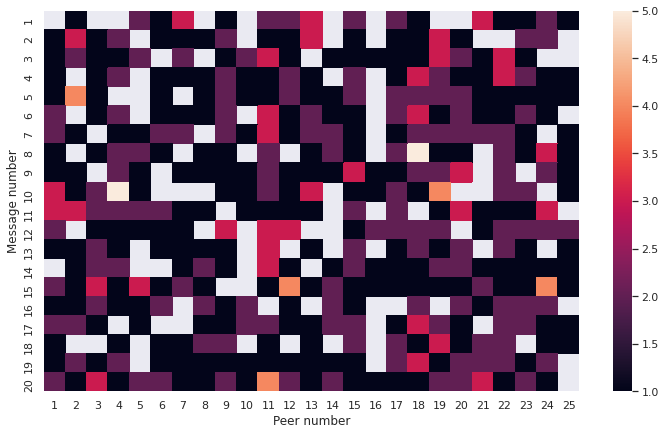

In [38]:
def calc_overhead(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].times_seen
    for k, times in store.items():
        msg_num, client_id = k.split('_')
        yield (int(msg_num), int(times))
    
def get_overhead_table(sim, storage_name):
    return pd.DataFrame({k: dict(calc_overhead(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()

oh = get_overhead_table(net_sim, 'msg_time')
show_heat_map(oh)            

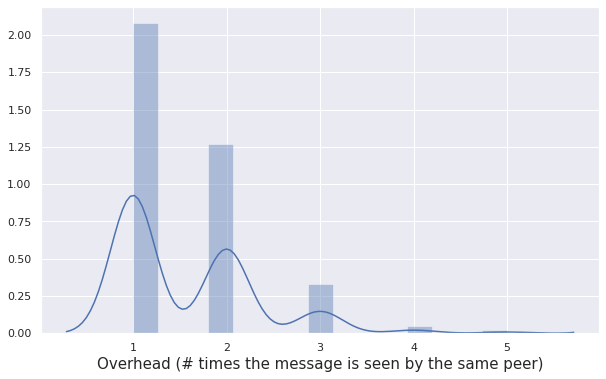

In [39]:
# Show average overhead on message
def show_overhead_hist(overhead_table, title=""):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    sns.distplot(overhead_table, norm_hist=True)
    plt.xlabel('Overhead (# times the message is seen by the same peer)', fontsize=15)

show_overhead_hist(oh)




# Achieving full convergence 


This is an exploratory section where you have one task: **full convergence**.

As it is clear from our gossip protocol, full convergence is not possible with this set of parameter configuration. What can we do to achieve it? 

Possible options: 

1. Tweak parameter of gossip protocol. Change `ttl` and `fanout`. But keep in mind that it will increase the load on the network. As our gossip protocol is blind, it might take a lot of resources to guarantee convergence. Also, `ttl` and `fanout` highly depend on the network topology. Try to change that and find out what the optimal `ttl` is as a function of the number of peers?     
2. Change the network topology. What is an optimal topology for convergence?  
3. Implement better gossip protocols. We were using a naive gossip, but there better variations based on [rumor-mongering and anti-entropy](http://www.cs.cornell.edu/courses/cs6410/2016fa/slides/19-p2p-gossip.pdf). A good start will be change gossip protocol to *pull-based* instead of *push-based*. 




Report for your gossip protocol: 
- If it achieves convergence. 
- Convergence speed.
- Average time to convergence.
- The overhead on peers. 


Report your findings: 
- How can you improve your gossip protocol further? 
- Try to change the topology? Can you still achieve convergence? 
- How big is the overhead on peers? How can you improve it? 



,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,115.429953,37.871980,115.487472,115.431852,115.414656,115.543601,37.437666,37.700047,37.656094,115.409774,...,115.352247,73.807843,37.814402,115.466681,73.777920,37.747246,73.082068,73.850302,37.677401,37.769818
2,115.466591,37.723726,115.451588,115.455814,115.462917,115.481733,37.482667,37.699187,37.740497,115.489778,...,115.449957,73.967818,37.788135,115.474853,74.431750,37.703989,73.898742,75.285246,38.019513,37.716129
3,114.268944,36.510797,114.226936,114.323930,114.287835,114.326644,36.269053,36.531266,36.637967,114.275162,...,114.298787,72.923516,36.505302,114.222652,74.252999,36.518679,72.097404,72.847546,36.523155,36.499607
4,113.957831,36.287569,114.038470,113.973738,113.999538,113.968466,36.005229,36.244980,36.262150,113.997989,...,113.966447,73.148588,36.385401,114.067178,73.717071,36.293627,72.989942,72.225292,36.299112,36.259073
5,114.846787,37.230228,114.918495,114.844669,114.951859,114.867940,36.852318,37.128526,37.105061,115.000771,...,114.868826,73.578822,37.250121,114.871862,73.155960,37.074218,73.924348,73.150136,37.066995,37.072321
6,115.094144,37.395775,115.128259,115.112424,115.197942,115.136607,37.149368,37.401670,37.542032,115.117885,...,115.102197,74.261662,37.388724,115.137916,73.922665,37.406598,73.957072,74.583101,37.367614,37.530557
7,115.215751,37.379573,115.220543,115.143625,115.106287,115.237500,37.152147,37.727878,37.387358,115.186678,...,115.159081,73.275147,37.410244,115.147855,73.984420,37.384329,73.582833,73.804166,37.410057,37.564657
8,115.186249,37.669556,115.130691,115.180245,115.121613,115.170058,37.213137,37.530185,37.477287,115.207359,...,115.192697,73.369098,37.412049,115.169396,73.828490,37.445992,73.882156,74.252814,37.474419,37.448170
9,114.039105,36.363453,114.033480,113.967193,114.023302,114.051141,35.998084,36.227435,36.241359,113.965820,...,114.056841,73.097413,36.269622,113.967519,73.325824,36.207207,72.672595,71.960047,36.237082,36.235013
10,115.236736,37.354059,115.094391,115.107419,115.145355,115.171981,37.145224,37.412649,37.379172,115.193734,...,115.078745,73.606067,37.445500,115.205333,73.774175,37.456203,73.565771,73.833508,37.417473,37.512727


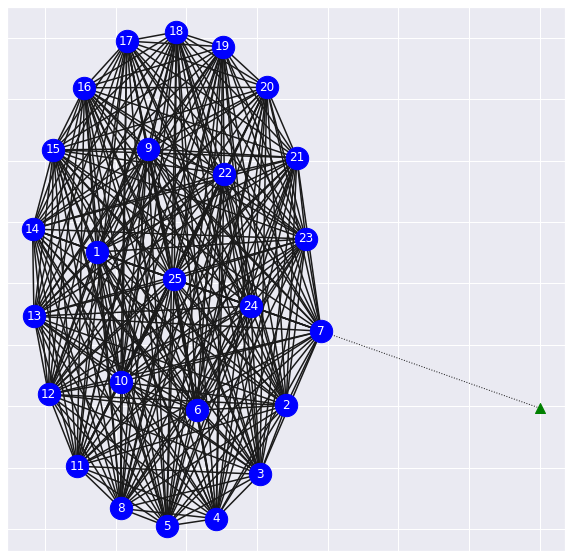

In [41]:
# Option 1 & 2: We are going to adjust ttl and fanout for *structured* topologies.
# 
# In an *unstructured* or random topology, it is hard to derive the function for ttl and fanout with respect to the number of nodes.
# Therefore, we are going to explore three structured topologies and see their behaviour.
# (1) Complete or Fully connected network, (2) Ring network, (3) 2-D Grid network

# (a) Complete network:
# Each node in the network is connected to every other node. Therefore, if we keep fanout=(N-1) and ttl=1, then we should achieve the convergence.
def prepare_complete_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.complete_graph(num_peers)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

G = prepare_complete_topology()
visualize_peer_client_network(G)

# Configuration used to set the values of message producer
class ClientMsgProducerConfig(Config):
    init_timeout = 10000 # Add some delay so that the peer network is built before starting with this message.class ClientMsgProducerConfig
    init_ttl = 1
    
# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}
    fanout = 24 # (N - 1)
    
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, {BaseConnectionManager: None, 
                                                MessageProducer: ClientMsgProducerConfig})}


net_complete_sim = BaseSimulation(Locations, G, prepare_peer_types())
net_complete_sim.run(15_000)

df_complete = get_gossip_table(net_complete_sim, 'msg_time')
df_complete

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,114.441449,192.490914,229.246892,294.681184,360.148124,360.657004,361.131194,361.715558,362.206878,427.508355,...,398.299127,320.305672,254.846505,218.007230,180.650921,115.225651,114.932931,114.701409,114.478815,36.514915
2,114.220819,192.235167,229.901574,295.366119,360.959225,361.454260,362.115946,362.644592,363.164656,428.578833,...,396.623888,318.512354,252.946496,216.871094,180.454371,114.959499,114.713283,114.387384,114.109971,36.277770
3,114.827233,192.934841,229.824593,295.443254,360.801558,361.311959,361.814722,362.280747,362.804694,428.501507,...,398.538916,320.594271,254.843196,218.489390,181.216855,115.674320,115.399071,115.130537,114.900954,36.806190
4,114.947256,193.021001,228.886938,294.296409,359.735015,360.196489,360.790839,361.278581,361.823018,427.376903,...,399.350293,321.396721,255.940719,218.870836,181.040680,115.640579,115.391019,115.171291,114.908239,36.958523
5,114.132477,192.113164,229.026244,294.563646,360.104940,360.584242,361.077323,361.553120,362.061335,427.689720,...,398.181500,320.055818,254.421370,217.579516,180.379416,114.921608,114.667743,114.435974,114.150734,36.151857
6,114.339764,192.287968,229.515565,295.347843,360.587201,361.084560,361.556325,362.078675,362.547914,428.047472,...,398.274380,320.326560,254.822809,217.376398,180.394727,115.151147,114.907750,114.634035,114.383937,36.319437
7,115.411971,193.469839,230.149605,295.952047,361.425348,361.934648,362.462603,363.010042,363.470402,428.816541,...,398.598039,320.584699,255.130265,218.469723,181.761242,116.237070,115.978789,115.740236,115.480600,37.452161
8,114.049804,192.093287,229.380843,294.922049,360.279645,360.794549,361.317908,361.795585,362.275832,427.775756,...,397.603373,319.631684,254.064674,216.672675,180.585109,115.085814,114.729323,114.455345,114.139878,36.072645
9,115.679078,193.682485,230.290096,295.613256,361.139090,361.684257,362.166338,362.660495,363.203194,428.887183,...,397.996717,320.045110,254.499085,217.842799,182.088223,116.445770,116.157478,115.913856,115.638224,37.639435
10,115.519446,193.467285,229.992504,295.287809,360.771824,361.302265,361.833349,362.328409,362.833606,428.501934,...,399.127674,321.112537,255.585428,218.825853,181.917202,116.424602,116.097851,115.822853,115.548170,37.493908


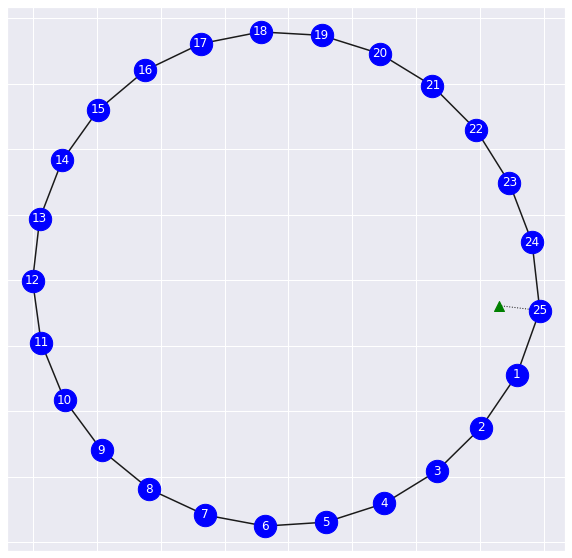

In [42]:
# (b) Ring network.
# Each node connected to two neighbours nodes in a circular fashion. Therefore, if we keep fanout=2 and ttl=(N/2), then we should see the convergence.
def prepare_ring_topology(num_peers=25, num_clients=1):    
    # Create network topology
    G = nx.cycle_graph(num_peers)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

G = prepare_ring_topology(25,1)
visualize_peer_client_network(G)

# Configuration used to set the values of message producer
class ClientMsgProducerConfig(Config):
    init_timeout = 10000 # Add some delay so that the peer network is built before starting with this message.class ClientMsgProducerConfig
    init_ttl = 25 // 2 # ( N / 2)
    
# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}
    fanout = 2
    
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, {BaseConnectionManager: None, 
                                                MessageProducer: ClientMsgProducerConfig})}

net_ring_sim = BaseSimulation(Locations, G, prepare_peer_types())
net_ring_sim.run(15_000)

df_ring = get_gossip_table(net_ring_sim, 'msg_time')
df_ring

Client edges:  [(26, 6)]


,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,101.575563,101.935693,102.195604,74.610084,110.414370,36.297615,36.779345,102.449557,74.324295,152.257097,...,73.403577,73.641273,151.669367,74.324620,110.166155,73.663944,109.713162,151.987829,152.252395,147.463746
2,101.637876,101.864376,102.148795,73.182591,110.562249,36.023245,36.518921,102.014459,72.846179,150.862945,...,72.557449,72.294089,150.341489,72.926555,109.185305,72.779025,109.490477,150.603816,150.828792,145.804526
3,102.297827,102.518230,102.839939,74.562428,110.697811,36.672061,37.137271,102.701486,74.314536,152.270547,...,73.543863,73.781212,151.825982,74.462437,110.202938,73.804979,110.701248,152.107173,152.365497,147.036234
4,102.378255,102.648221,102.884172,74.958588,111.648722,36.747244,37.252194,102.683287,74.710479,152.586969,...,73.758195,73.945054,151.916982,74.604783,111.546969,73.991410,109.899574,152.203101,152.422097,147.409565
5,102.692387,102.940078,103.200241,75.411467,112.394097,36.992800,37.552428,102.983703,75.131949,153.126455,...,74.402026,74.641321,152.635502,75.130066,110.886968,74.683286,110.875791,152.845318,153.149614,147.595140
6,102.087385,102.359775,102.661728,74.352060,111.089264,36.511514,37.017425,102.425334,74.116871,152.100893,...,73.394569,73.671468,151.603967,74.100814,109.937181,73.684199,109.407323,151.874323,152.105346,147.740286
7,102.934586,103.216929,103.490466,75.765263,113.186526,37.530385,38.147593,103.666996,75.338643,153.350721,...,74.479180,74.729300,152.633375,75.331751,111.422870,74.732715,111.970410,152.892319,153.195586,148.631482
8,101.612880,101.922129,102.202623,74.266387,110.997159,36.241885,36.779799,102.088382,73.957655,151.984349,...,73.268655,73.497212,151.445815,74.017370,110.445830,73.572850,110.749580,151.670355,151.951552,147.455327
9,101.917056,102.209969,102.534100,74.648825,111.730310,36.540394,37.077508,102.441300,74.316754,152.306193,...,73.575636,73.799805,151.833566,74.287827,111.471750,73.852343,110.056030,152.125073,152.231790,147.935192
10,101.676039,101.982268,102.286922,74.027544,111.445947,36.376737,36.924264,102.550169,73.700597,151.538290,...,72.866628,73.140865,151.129459,73.624678,110.725305,73.200074,110.152440,151.393338,151.621463,148.445920


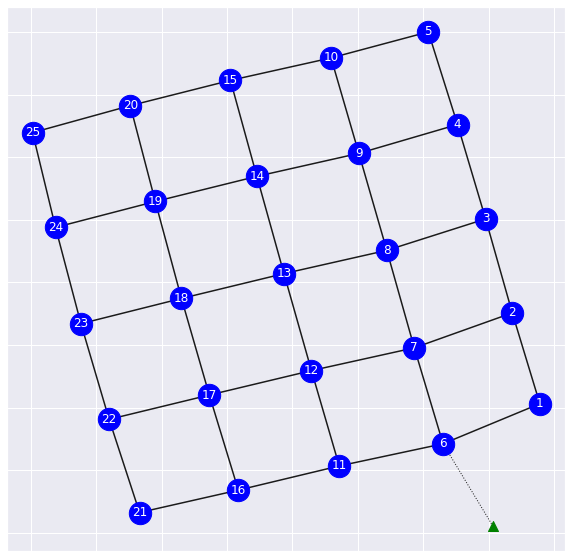

In [43]:
# (3) 2-D Grid network
# Nodes are connected in a grid (row, col) fashion. Each corner node is connected to 2 other boundary nodes. Each boundary node is connected to three other nodes. And, the rest of the nodes are connected to four other nodes.
# Therefore, if we keep fanout = 3 and ttl = (row - 1 + col - 1), then we should see the convergence.
import math

def prepare_grid_topology(num_row=5, num_col=3, num_clients=1):
    num_peers = num_row * num_col
    G = nx.grid_2d_graph(num_row,num_col)
    labels = {}
    for (i, j) in G.nodes():
        label = i * num_col + j + 1
        labels[(i,j)] = label
        
    nx.relabel_nodes(G, labels ,copy=False)
    
    # Connect the client node to a random peer
    client_edges = [(i, choice(list(G.nodes()))) for i in range(num_peers+1, num_clients+num_peers+1)]
    # client_edges = [(26, 1)]
    print("Client edges: ", client_edges)
    G.add_edges_from(client_edges)

    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    # Assign a peer type to the peers
    nx.set_node_attributes(G, types_map , 'type')
    return G

row = 5
col = 5
G = prepare_grid_topology(row, col)
visualize_peer_client_network(G)

# Configuration used to set the values of message producer
class ClientMsgProducerConfig(Config):
    init_timeout = 10000 # Add some delay so that the peer network is built before starting with this message.class ClientMsgProducerConfig
    init_ttl = (row - 1) + (col - 1)
    
# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}
    fanout = 3
    optimization = True
    
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,   {BaseConnectionManager: None,
                                                GossipService: GossipConfig }),
             'client': PeerType(PeerConfig, {BaseConnectionManager: None, 
                                                MessageProducer: ClientMsgProducerConfig})}

net_grid_sim = BaseSimulation(Locations, G, prepare_peer_types())
net_grid_sim.run(15_000)

df_grid = get_gossip_table(net_grid_sim, 'msg_time')
df_grid

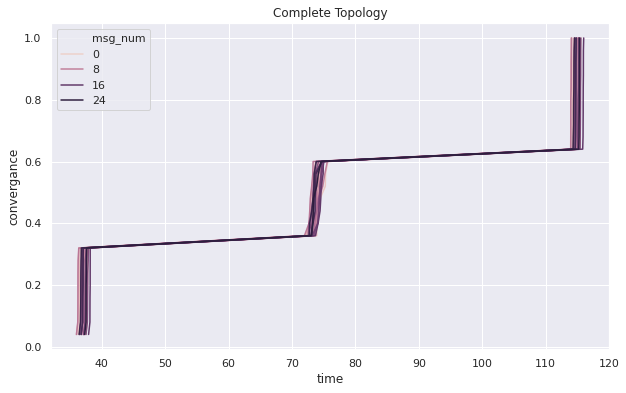

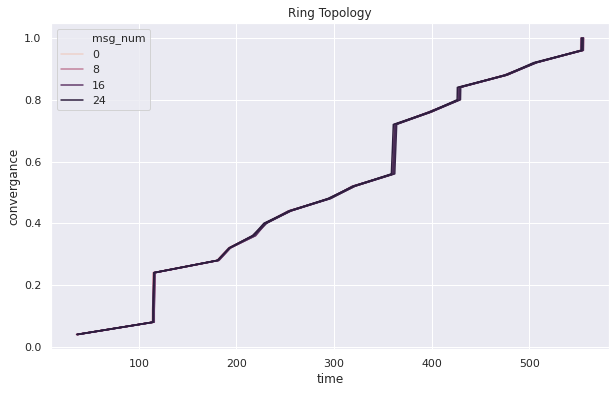

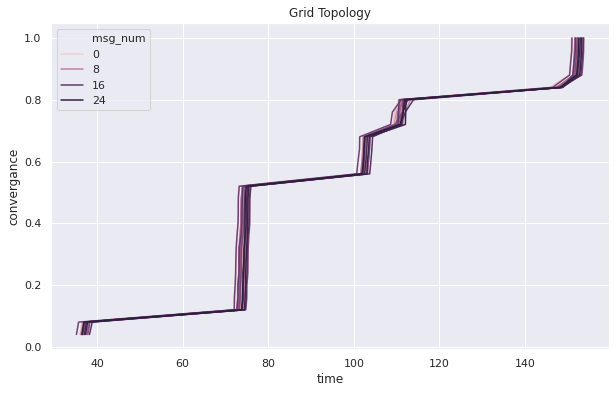

In [44]:
# Here, we will compare the convergence speed of our three structured topologies.
show_convergence(df_complete, "Complete Topology")
show_convergence(df_ring, "Ring Topology")
show_convergence(df_grid, "Grid Topology")

/home/vinod/.local/share/virtualenvs/BlockchainEngineering--qQNnRqa/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/vinod/.local/share/virtualenvs/BlockchainEngineering--qQNnRqa/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


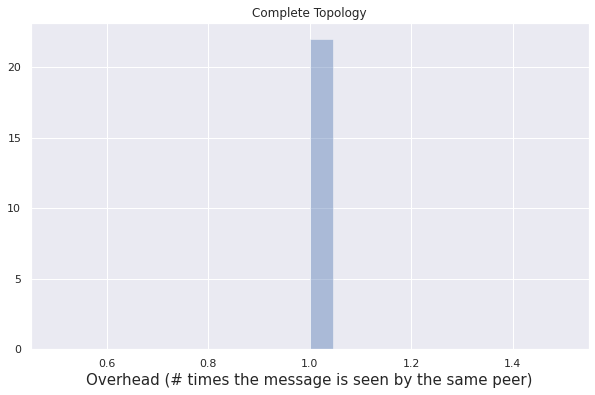

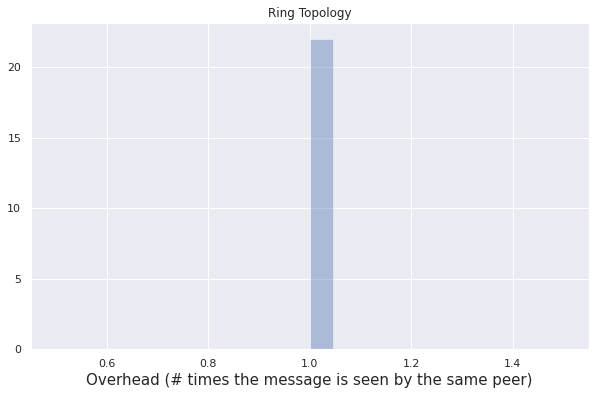

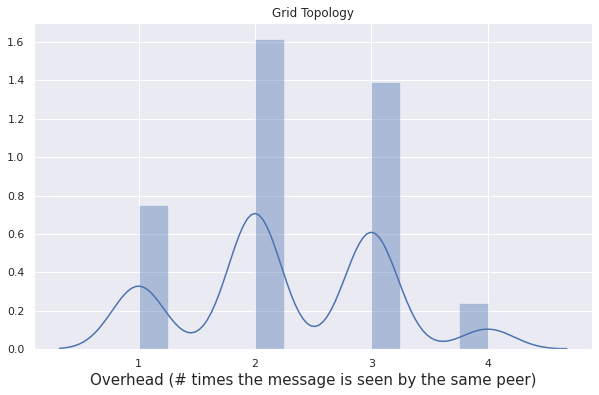

In [46]:
# As expected, the Complete topology has faster convergence speed of around 115ms, because it has the shortest diameter of 1.
# Next, the Ring topology has diameter of N / 2 which is higher than the 2D-Grid topology, which has diameter of around 2*(sqrt(N)-1) when N is a perfect square.
# Therefore, 2-D Grid topology has better convergence speed than the Ring topology.

# Now let's compare the average overhead on the nodes.
oh_complete = get_overhead_table(net_complete_sim, 'msg_time')
oh_ring= get_overhead_table(net_ring_sim, 'msg_time')
oh_grid = get_overhead_table(net_grid_sim, 'msg_time')
show_overhead_hist(oh_complete, "Complete Topology")
show_overhead_hist(oh_ring, "Ring Topology")
show_overhead_hist(oh_grid, "Grid Topology")

# As expected, the Complete topology and Ring topology has almost the constant overhead, i.e., only one time, the messages are seen.
# However, the 2-D topology has a huge overhead, i.e., some messages are seen upto 200 times.
# Therefore, we introduce one optimization in the Gossip protocol to drop the message if it's already seen. This optimization
# has tremendously reduced the overhead without affecting the convergence. Now, we should have the overhead of 3-4 times for the same message.

# Choice of topology
# 1. Ideally, the complete topolgy performs best. But it's not practically feasible to have overlay of complete network.
# 2. the Ring topology does have a low overhead compared to the 2-D Grid topology but has low convergence speed. Moreover, it has a single-point of failure.
# 3. the 2D-Grid topology has a good balance of convergence speed and the overhead.

Finally, for reproducibility you can save the experiment data. Use `.save_experiment(dir)` to save configurations for your experiment to a `dir` directory: locations, topology and peer services.  Whole experiment will be saved in yaml files. As they are saved in human readable format, you can always open and read the experiment configurations.

By default, it will not save the reference to implementations as it is not always [safe to do](https://github.com/yaml/pyyaml/wiki/PyYAML-yaml.load(input)-Deprecation). But if you are confident enough that other notebooks can find the service implementation feel free to use `include_module_classes=True`. 

For example, `GossipService` and `MessageProducer` cannot be saved as they are defined only within the scope of one notebook. If you want to include also implementations of services make sure to save them first somewhere where other notebooks can find it, e.g. to save into `py` file in `p2psimpy.services` module. 

In [47]:
net_grid_sim.save_experiment(expr_dir='gossip_expr_custom')

In [48]:
net_sim.save_experiment(expr_dir='gossip_expr')